In [77]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [78]:
cwd = "/content/drive/MyDrive/6.7900 Final Project"
os.chdir(cwd)
# !pwd
# os.chdir("/content")
# !pwd

In [79]:
# load in metadata
metadata_path = f'{cwd}/ArtBench-10.csv'

In [80]:
# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam

import torchvision
from torchvision import datasets, transforms

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import math

from IPython.display import Image, display

In [81]:
mini_dataset_path = f'{cwd}/miniroot'
dataset_path = 'artbench-10-imagefolder-split'
dataset_32_path = 'artbench-10-imagefolder-split-32'
dataset_32_path_test = 'artbench-10-imagefolder-split-32-test'

In [82]:
BATCH_SIZE = 32
NUM_WORKERS = 2

In [83]:
# !tar -xvf '/content/drive/MyDrive/6.7900 Final Project/artbench-10-python.tar.gz'

In [84]:
from torchvision.datasets import CIFAR10

class ArtBench10(CIFAR10):

    base_folder = "artbench-10-batches-py"
    url = "https://artbench.eecs.berkeley.edu/files/artbench-10-python.tar.gz"
    filename = "artbench-10-python.tar.gz"
    tgz_md5 = "9df1e998ee026aae36ec60ca7b44960e"
    train_list = [
        ["data_batch_1", "c2e02a78dcea81fe6fead5f1540e542f"],
        ["data_batch_2", "1102a4dcf41d4dd63e20c10691193448"],
        ["data_batch_3", "177fc43579af15ecc80eb506953ec26f"],
        ["data_batch_4", "566b2a02ccfbafa026fbb2bcec856ff6"],
        ["data_batch_5", "faa6a572469542010a1c8a2a9a7bf436"],
    ]

    test_list = [
        ["test_batch", "fa44530c8b8158467e00899609c19e52"],
    ]
    meta = {
        "filename": "meta",
        "key": "styles",
        "md5": "5bdcafa7398aa6b75d569baaec5cd4aa",
    }

In [85]:
# play around with other transformations later
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

train_transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [86]:
# train_dataset = ArtBench10(root=dataset_32_path, download=True, train=True, transform=train_transform_32)
# test_dataset = ArtBench10(root=dataset_32_path_test, download=True, train=False, transform=train_transform_32)

# # classes
# classes = np.array(train_dataset.classes)
# class_idxs = np.array(list(train_dataset.class_to_idx.values()))

In [87]:
DATASET = dataset_path
# training dataset
train_dataset = datasets.ImageFolder(
    root=f'{DATASET}/train',
    transform=train_transform
)
# test dataset
test_dataset = datasets.ImageFolder(
    root=f'{DATASET}/test',
    transform=test_transform
)

In [88]:
# classes
classes = np.array(train_dataset.classes)
class_idxs = np.array(list(train_dataset.class_to_idx.values()))

In [89]:
# only select surrealism (7) and impressionism (0)
labels = [3, 8]
train_indices = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
test_indices = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

# training data loader
class2_train_loader = DataLoader(
    Subset(train_dataset, train_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
# # # validation data loader
# # validation_loader = DataLoader(
# #     validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS
# # )
# # test data loader
class2_test_loader = DataLoader(
    Subset(test_dataset, test_indices), batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)

In [90]:
# print(f"Training Dataset Length: {len(Subset(train_dataset, train_indices))}")
print(f"Training Dataset Length: {len(train_dataset)}")
print(f"Training Dataset Length: {len(Subset(train_dataset, train_indices))}")
# print(f"Validation Dataset Length: {len(validation_dataset)}")
# print(f"Testing Dataset Length: {len(Subset(test_dataset, test_indices))}")
print(f"Testing Dataset Length: {len(test_dataset)}")
print(f"Testing Dataset Length: {len(Subset(test_dataset, test_indices))}")
print(f"Classes:", classes)
print(train_dataset[0][0].shape, classes[train_dataset[0][1]])

Training Dataset Length: 50000
Training Dataset Length: 10000
Testing Dataset Length: 10000
Testing Dataset Length: 2000
Classes: ['art_nouveau' 'baroque' 'expressionism' 'impressionism'
 'post_impressionism' 'realism' 'renaissance' 'romanticism' 'surrealism'
 'ukiyo_e']
torch.Size([3, 256, 256]) art_nouveau


In [91]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
# cnn_normalization_mean = torch.tensor([0.5,0.5,0.5])
# cnn_normalization_std = torch.tensor([0.5,0.5,0.5])

reverse_transformations = transforms.Compose([
      transforms.Lambda(lambda t: (t + 1) / 2),
      # transforms.Lambda(lambda t: t.permute(1, 2, 0)), # c,h,w to h,w,c
      transforms.ToPILImage()
])

reverse_transformations_vgg = transforms.Compose([
      # transforms.Lambda(lambda t: (t + 1) / 2),
      # transforms.Lambda(lambda t: t.permute(1, 2, 0)), # c,h,w to h,w,c
      transforms.ToPILImage()
])

def show_tensor_image_batch_vgg(images, single_row = False):
  images = images.detach().cpu().clone()
  for i in range(len(images)):
    for channel in range(3):
      images[i][channel] = images[i][channel] * cnn_normalization_std[channel] + cnn_normalization_mean[channel]
  if (single_row):
    plt.imshow(reverse_transformations_vgg(torchvision.utils.make_grid(images, nrow=images.shape[0])))
  else:
    plt.imshow(reverse_transformations_vgg(torchvision.utils.make_grid(images)))

def show_tensor_image_vgg(images):
  images = images.clone()
  if (len(images.shape) == 4):
    images = images[0, :, :, :] # show the first image in the batch
  for channel in range(3):
    images[channel] = images[channel] * cnn_normalization_std[channel] + cnn_normalization_mean[channel]
  plt.imshow(reverse_transformations_vgg(images), cmap='gray')

def show_tensor_image_batch(images, single_row = False):
  images = images.detach().cpu()
  if (single_row):
    plt.imshow(reverse_transformations(torchvision.utils.make_grid(images, nrow=images.shape[0])))
  else:
    plt.imshow(reverse_transformations(torchvision.utils.make_grid(images)))

def show_tensor_image(images):
  if (len(images.shape) == 4):
    images = images[0, :, :, :] # show the first image in the batch
  plt.imshow(reverse_transformations(images), cmap='gray')

In [92]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

expressionism


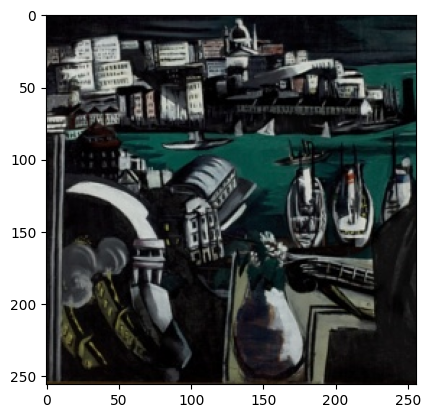

In [93]:
print(classes[labels[0]])
show_tensor_image(images)

['expressionism' 'expressionism' 'baroque' 'realism' 'surrealism'
 'baroque' 'realism' 'renaissance' 'art_nouveau' 'surrealism' 'baroque'
 'surrealism' 'ukiyo_e' 'renaissance' 'art_nouveau' 'expressionism'
 'realism' 'post_impressionism' 'realism' 'ukiyo_e' 'renaissance'
 'expressionism' 'renaissance' 'art_nouveau' 'baroque' 'baroque'
 'impressionism' 'romanticism' 'baroque' 'post_impressionism'
 'post_impressionism' 'surrealism']
torch.Size([32, 3, 256, 256])


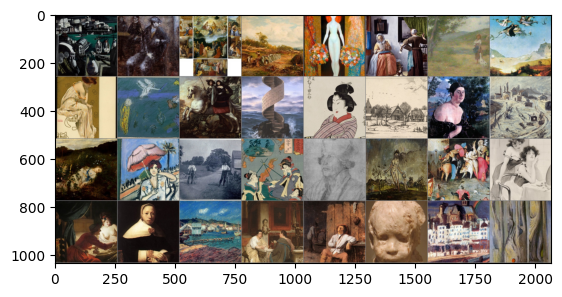

In [94]:
print(classes[labels])
show_tensor_image_batch(images)
print(images.shape)

In [95]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


# part 0: just playing around with stuff

In [96]:
# more packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [97]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [98]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [99]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [100]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [101]:
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

In [102]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        # self.mean = torch.tensor(mean).view(-1, 1, 1)
        # self.std = torch.tensor(std).view(-1, 1, 1)
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [103]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

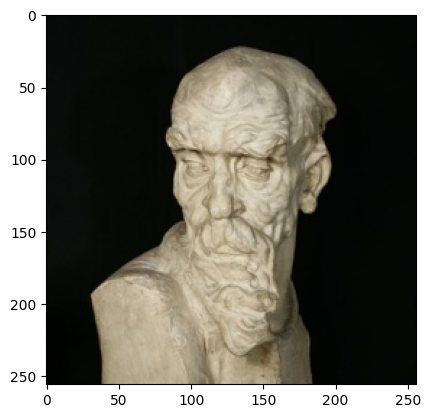

In [104]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]
show_tensor_image(image)

In [105]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [106]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                print(sl.loss)
                style_score += sl.loss
            for cl in content_losses:
                print(cl.loss)
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [107]:
transform = transforms.ToPILImage()

['impressionism' 'impressionism' 'expressionism' 'art_nouveau'
 'romanticism' 'ukiyo_e' 'baroque' 'surrealism' 'romanticism'
 'art_nouveau' 'ukiyo_e' 'renaissance' 'art_nouveau' 'impressionism'
 'ukiyo_e' 'realism' 'realism' 'baroque' 'baroque' 'post_impressionism'
 'ukiyo_e' 'baroque' 'realism' 'realism' 'post_impressionism' 'realism'
 'art_nouveau' 'romanticism' 'art_nouveau' 'surrealism' 'art_nouveau'
 'art_nouveau']


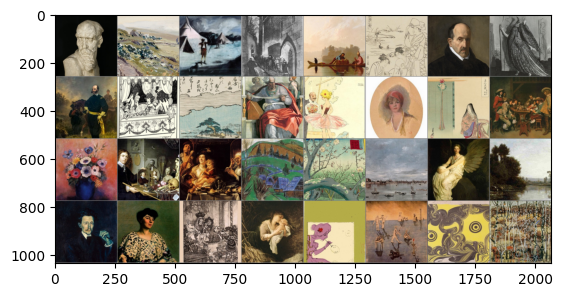

In [108]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
print(classes[labels])
show_tensor_image_batch(images)

content_img = images[:1]
style_img = images[3:]
input_img = images[:1]

In [109]:
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img)

# # plt.figure()
# # imshow(output, title='Output Image')

# # sphinx_gallery_thumbnail_number = 4
# # plt.ioff()
# # plt.show()

In [110]:
# show_tensor_image(output)

# part 1: playing around with adaIn

In [111]:
# style image
img_dir = "/content/drive/MyDrive/6.7900 Final Project/imgs"
os.chdir(img_dir)
!ls

alpha0.jpg    alpha25.jpg  alpha75.jpg		   surrealism-test.jpg
alpha100.jpg  alpha50.jpg  impressionism-test.jpg


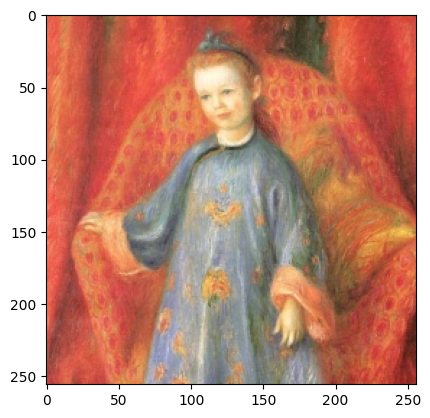

In [112]:
img_content = Image.open("impressionism-test.jpg")
img_style = Image.open("surrealism-test.jpg")
img_content = test_transform(img_content)
img_style = test_transform(img_style)

# show content image
show_tensor_image(img_content)

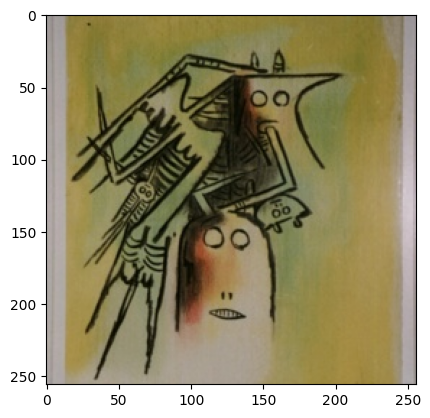

In [113]:
show_tensor_image(img_style)

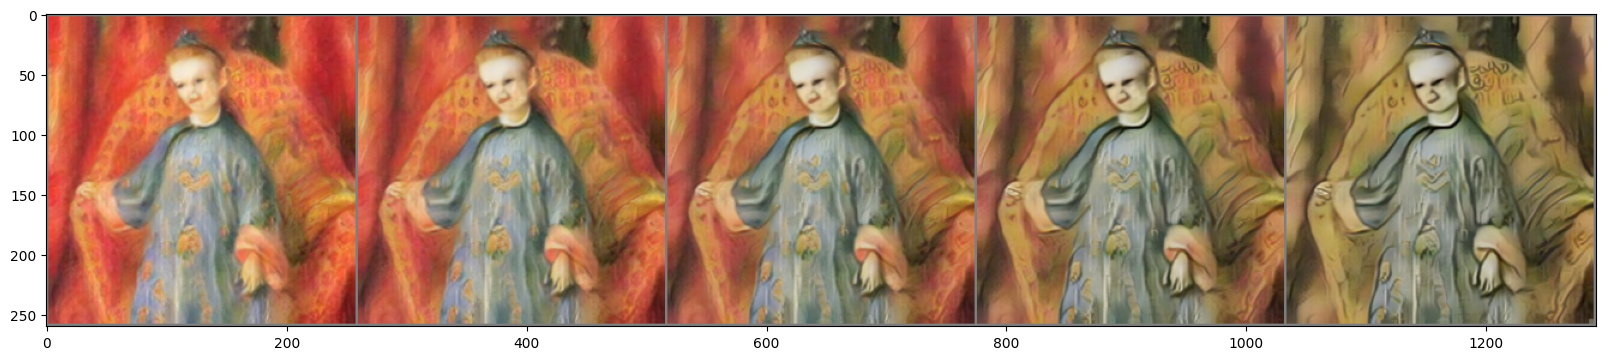

In [114]:
img_paths = ['alpha0.jpg', 'alpha25.jpg', 'alpha50.jpg', 'alpha75.jpg', 'alpha100.jpg']

batch = []

for path in img_paths:
  img_ai = Image.open(path)
  img_ai = test_transform(img_ai)
  batch.append(img_ai)

plt.figure(figsize=(20,20))
batch = torch.stack(batch)
show_tensor_image_batch(batch)

In [115]:
from torchvision import models
vgg = models.vgg19(pretrained=True)
vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=2)
vgg = vgg.to(device)

save_path = "vgg_model.pt"
save_loss_path = "vgg_model_loss"
save_loss_test_path = "vgg_model_test_loss"
save_accuracy_path = "vgg_model_accuracy"
save_accuracy_test_path = "vgg_model_accuracy_test"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# set up PCA

In [116]:
# CHANGE according to whatever labels you have
def map_labels(labels):
  return torch.tensor([0 if label == 8 else 1 for label in labels]).to(device)

criterion = nn.CrossEntropyLoss().to(device)
def evaluate(model, loader):
  correct = 0
  total = 0
  total_loss = 0.0
  iters = 0
  total_classes = [0 for i in range(10)]
  correct_classes = [0 for i in range(10)]
  with torch.no_grad():
    for inputs, labels in tqdm(loader, desc="Testing", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = map_labels(labels)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()
        iters += 1

        # for i, label in enumerate(labels):
        #   if (label == predicted[i]):
        #     correct_classes[label]+=1
        #   total_classes[label]+=1

  accuracy = correct / total
  print(f'Test Accuracy: {accuracy * 100:.2f}%')
  # print(correct_classes)
  # print(total_classes)
  # print(np.array(correct_classes)/np.array(total_classes))
  return correct, total, total_loss / iters

In [117]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model, layers):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*original_model.features.children())
        self.save_layers = layers

    def forward(self, x):
      out = []
      for i, layer in enumerate(self.features):
        x = layer(x)
        if i+1 in self.save_layers:
          flattened_feature = x.view(x.size(0), -1)
          out.append(flattened_feature)
      return out

class LinearClassifier(nn.Module):
    def __init__(self, original_model, in_features, num_classes):
        super(LinearClassifier, self).__init__()
        self.classifier = original_model.classifier
        self.classifier[-1] = nn.Linear(in_features=self.classifier[-1].in_features, out_features=num_classes)
        self.classifier[0] = nn.Linear(in_features=in_features, out_features = self.classifier[0].out_features)

    def forward(self, x):
        x = self.classifier(x)
        return x

In [118]:
os.chdir("/content/drive/MyDrive/6.7900 Final Project/")

In [119]:
model = torch.load(save_path)
loss_list = torch.load(save_loss_path)
accuracy_list = torch.load(save_accuracy_path)
loss_test_list = torch.load(save_loss_test_path)
accuracy_test_list = torch.load(save_accuracy_test_path)
vgg.load_state_dict(model)
vgg = vgg.eval()

In [120]:
vgg_feature_extractor = FeatureExtractor(vgg, [5, 10, 19, 28, 37])
vgg_feature_extractor.eval()

FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride

In [121]:
train_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)
])
test_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)
])
labels = [8,9]
train_indices = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
test_indices = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]
# data loaders
DATASET = dataset_path
# training dataset
vgg_train_dataset = datasets.ImageFolder(
    root=f'{DATASET}/train',
    transform=train_transform_vgg
)
# test dataset
vgg_test_dataset = datasets.ImageFolder(
    root=f'{DATASET}/test',
    transform=test_transform_vgg
)
vgg_train_loader = DataLoader(
    Subset(vgg_train_dataset, train_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
vgg_test_loader = DataLoader(
    Subset(vgg_test_dataset, test_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
# vgg_train_loader = DataLoader(
#     vgg_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
# )
# vgg_test_loader = DataLoader(
#     vgg_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
# )
dataloader = vgg_test_loader

In [156]:
get_batches = 2

features = []
labels = []

with torch.no_grad():
  images = []
  labels = []
  for i in range(get_batches):
      images_i, labels_i = next(iter(dataloader))
      images.append(images_i)
      labels.append(labels_i)

  images = torch.cat(images, dim=0)
  labels = torch.cat(labels, dim=0)
  print(images.shape)
  features = vgg_feature_extractor(images.to(device))

labels = map_labels(labels).detach().cpu()
print(labels)

torch.Size([64, 3, 224, 224])
tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0])


[torch.Size([64, 802816]), torch.Size([64, 401408]), torch.Size([64, 200704]), torch.Size([64, 100352]), torch.Size([64, 25088])]
torch.Size([64, 802816])
torch.Size([64, 401408])
torch.Size([64, 200704])
torch.Size([64, 100352])
torch.Size([64, 25088])


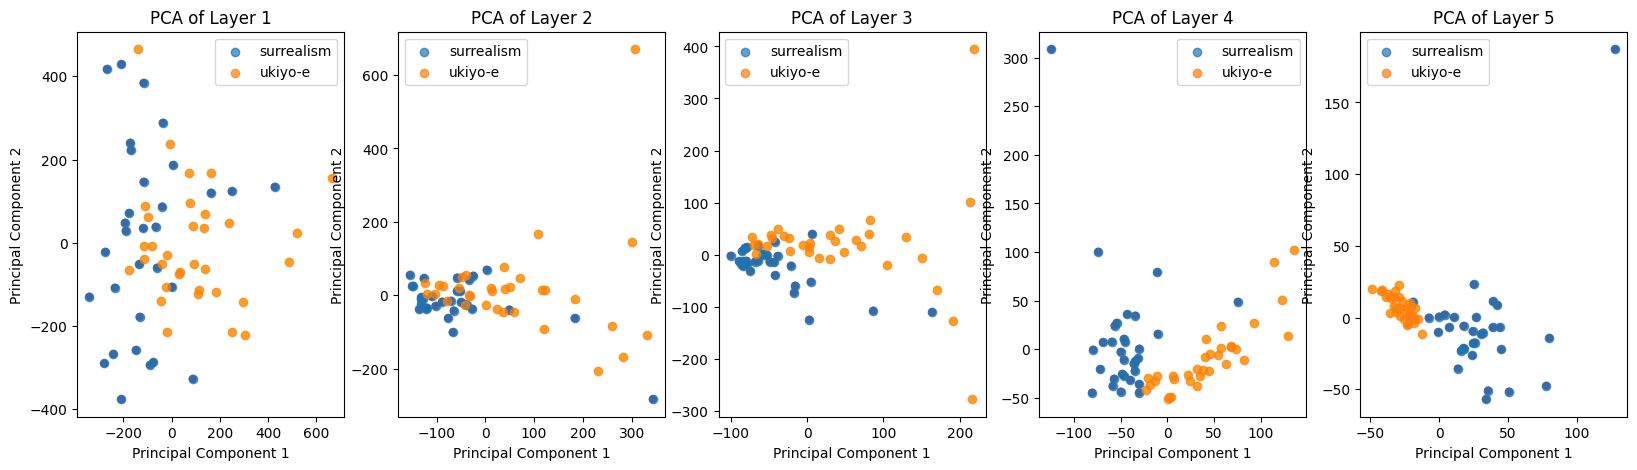

In [157]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming you want to plot the first four layers
num_layers_to_plot = 5

# Get the class names
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# class_names = ['0', '1']
class_names = {0: 'surrealism', 1: 'ukiyo-e'}

# Set up a grid for subplots
fig, axes = plt.subplots(1, num_layers_to_plot, figsize=(20, 5))

pca_results = []
pcas = []
scalers = []

print([feature.shape for feature in features])

for i, ax in enumerate(axes.flatten()):
    if i < len(features):
        layer_features = features[i]
        print(layer_features.shape)
        # Ensure the data is more than one-dimensional
        if layer_features.ndim > 1 and layer_features.shape[1] > 1:
            # Standardize the data
            scaler = StandardScaler()
            X_standardized = scaler.fit_transform(layer_features.detach().cpu())
            scalers.append(scaler)

            # Apply PCA
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(X_standardized)

            pca_results.append(pca_result)
            pcas.append(pca)

            # Scatter plot for this layer
            scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', edgecolor='none', alpha=0.7)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_title(f'PCA of Layer {i + 1}')

            # Create a legend with readable labels
            unique_labels = np.unique(labels)
            for unique_label in unique_labels:
                idx = labels == unique_label
                ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7)
            ax.legend()
        else:
            ax.set_visible(False)
    else:
        ax.set_visible(False)

# Show the plot
plt.show()

In [124]:
# # Assuming you want to plot the first four layers
# num_layers_to_plot = 5
# class_names = {0: 'surrealism', 1: 'ukiyo-e', 2: 'special'}

# num_rows = 5

# # Set up a grid for subplots
# fig, axes = plt.subplots(num_rows, num_layers_to_plot, figsize=(20,20))

# for i, ax in enumerate(axes.flatten()):
#   index = i - (i // num_rows) * num_rows
#   pca_result = pca_results[index]

#   # Scatter plot for this layer
#   scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', edgecolor='none', alpha=0.7)

#   # Create a legend with readable labels
#   labels[-1] = 2
#   unique_labels = np.unique(labels)
#   for unique_label in unique_labels:
#       if (unique_label != 2):
#         idx = labels == unique_label
#         ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7)
#       else:
#         idx = labels == unique_label
#         ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7, color='r')
#   ax.set_xticks([])
#   ax.set_yticks([])
#   ax.legend(fontsize='small')

# # Show the plot
# plt.show()

# load adaIN data and create trajectories

In [125]:
cwd = "/content/drive/MyDrive/6.7900 Final Project"
style_folder = "style-art"
output_00 = "output00"
output_25 = "output25"
output_50 = "output50"
output_75 = "output75"
output_100 = "output100"

In [160]:
idxs = [101,102,103,104,105,106,107,108,109,110,111,112]
styleimgs = [f"surrealism-{idx}.jpg" for idx in idxs]
curimgs = [f"ukiyo-e-{idx}_stylized_surrealism-{idx}.jpg" for idx in idxs]

In [161]:
def get_img_paths(imgpath):
  return [f"{cwd}/{output_00}/{imgpath}", f"{cwd}/{output_25}/{imgpath}", f"{cwd}/{output_50}/{imgpath}", f"{cwd}/{output_75}/{imgpath}", f"{cwd}/{output_100}/{imgpath}"]

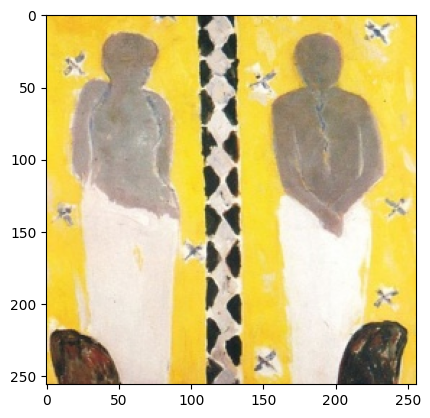

In [162]:
style_image = Image.open(f"{cwd}/{style_folder}/{styleimgs[0]}")
style_image = test_transform(style_image)
show_tensor_image(style_image)

In [163]:
img_paths = [path for curimg in curimgs for path in get_img_paths(curimg)]
batch = []

for path in img_paths:
  img_ai = Image.open(path)
  img_ai = test_transform_vgg(img_ai)
  batch.append(img_ai)

plt.figure(figsize=(20,20))
batch = torch.stack(batch)
show_tensor_image_batch_vgg(batch)

Output hidden; open in https://colab.research.google.com to view.

In [164]:
def interpolate_color(color1, color2, fraction):
    """
    Interpolate between two hex color values.

    Parameters:
    - color1 (str): Hex color code for the first color.
    - color2 (str): Hex color code for the second color.
    - fraction (float): Fraction (between 0 and 1) indicating the position between color1 and color2.

    Returns:
    - str: Hex color code of the interpolated color.
    """
    # Convert hex color codes to RGB values
    # rgb1 = np.array(plt.colors.to_rgb(color1))
    # rgb2 = np.array(plt.colors.to_rgb(color2))

    color1 = color1[1:]
    color2 = color2[1:]
    rgb1 = np.array([int(color1[i:i+2],16) for i in (0,2,4)])
    rgb2 = np.array([int(color2[i:i+2],16) for i in (0,2,4)])
    print(color1, color2, rgb1, rgb2)
    rgbmid = fraction * rgb1 + (1 - fraction) * rgb2

    def clamp(x):
      return max(0, min(x, 255))

    hex_color = "#{:02x}{:02x}{:02x}".format(int(rgbmid[0]), int(rgbmid[1]), int(rgbmid[2]))
    return hex_color

    # return hex

[torch.Size([60, 802816]), torch.Size([60, 401408]), torch.Size([60, 200704]), torch.Size([60, 100352]), torch.Size([60, 25088])]
5
5
5
124 64
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
124 64
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
124 64
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
124 64
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  14]
1f77b4 ff7f0e [ 31 119 180] [255 127  

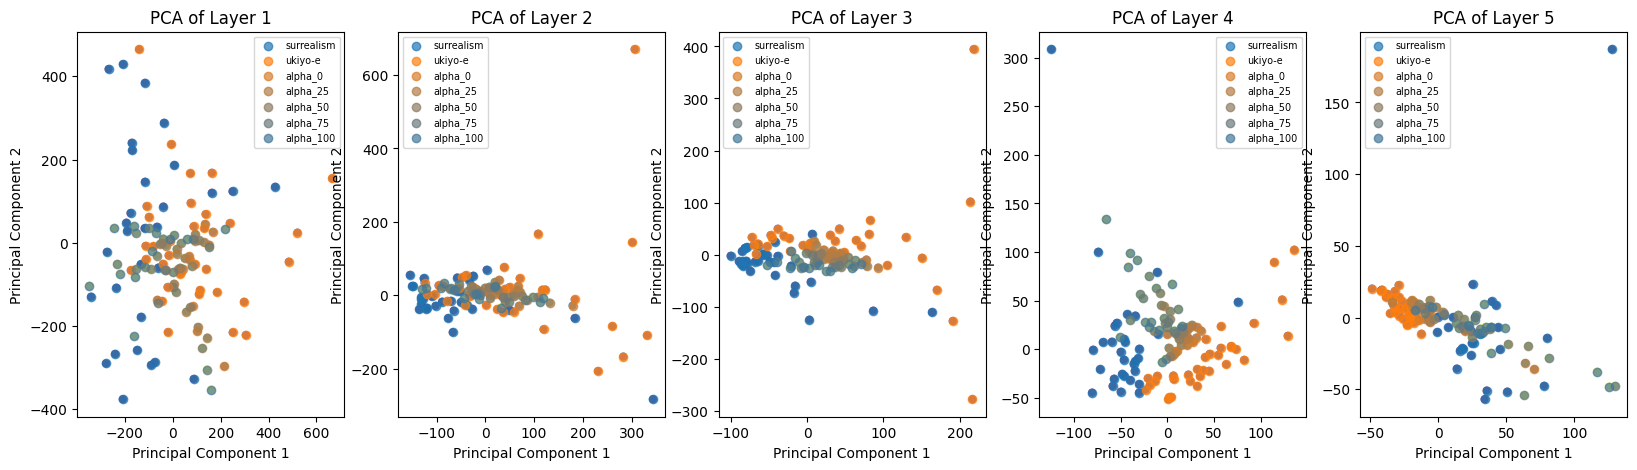

In [167]:
nst_features = vgg_feature_extractor(batch.to(device))
class_names = {0: 'surrealism', 1: 'ukiyo-e', 2: 'alpha_0', 3: 'alpha_25', 4: 'alpha_50', 5: 'alpha_75', 6: 'alpha_100'}
print([nst_feature.shape for nst_feature in nst_features])
print(len(pcas))
print(len(pca_results))
print(len(scalers))

num_layers_to_plot = 5
fig, axes = plt.subplots(1, num_layers_to_plot, figsize=(20, 5))

num_new = 12
new_labels = list(labels).copy()

for i in range(num_new):
  color = 2
  for alpha in range(5):
    new_labels.append(color)
    color += 1

default_blue = '#1f77b4'
default_orange = '#ff7f0e'
def get_color(label):
  if (label == 0):
    return default_blue
  elif (label == 1):
    return default_orange
  else:
    return interpolate_color(default_blue, default_orange, (label-1)/6)

for i, ax in enumerate(axes.flatten()):
    layer_features = nst_features[i]
    pca_result = pca_results[i]
    cur_pca = pcas[i]

    # Standardize the data
    scaler = scalers[i]
    X_standardized = scaler.transform(layer_features.detach().cpu())

    new_pca_features = cur_pca.transform(X_standardized)
    pca_result = np.concatenate((pca_result, new_pca_features), axis=0)

    print(len(pca_result[:, 0]), len(labels))

    # Scatter plot for this layer
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=new_labels, cmap='viridis', edgecolor='none', alpha=0.7)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'PCA of Layer {i + 1}')

    # Create a legend with readable labels
    unique_labels = np.unique(new_labels)
    for unique_label in unique_labels:
        idx = new_labels == unique_label
        ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7, color=get_color(unique_label.item()))
    ax.legend(fontsize="x-small")

plt.show()

In [166]:
print(len(pca_result[0]))
# # Assuming you want to plot the first four layers
# num_layers_to_plot = 5
# class_names = {0: 'surrealism', 1: 'ukiyo-e', 2: 'image'}

# num_rows = 1

# # Set up a grid for subplots
# fig, axes = plt.subplots(num_rows, num_layers_to_plot, figsize=(20,4*num_rows))

# for i, ax in enumerate(axes.flatten()):
#   index = i - (i // num_rows) * num_rows
#   pca_result = pca_results[index]

#   # Scatter plot for this layer
#   scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', edgecolor='none', alpha=0.7)

#   # Create a legend with readable labels
#   labels[-1] = 2
#   unique_labels = np.unique(labels)
#   for unique_label in unique_labels:
#       if (unique_label != 2):
#         idx = labels == unique_label
#         ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7)
#       else:
#         idx = labels == unique_label
#         ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7, color='r')
#   ax.set_xticks([])
#   ax.set_yticks([])
#   ax.legend(fontsize='small')

# # Show the plot
# plt.show()

2
